# Using Heuristics and Dynamic Programming to Solve the Class Scheduling Problem

In [41]:
import numpy as np
import random
import math
from functools import cmp_to_key
import networkx as nx

from course_version2 import *
from params_version2 import *
import matplotlib.pyplot as plt

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, generate a toy data set

Greedy algorithM:
- schedule the class with the most demand first
- scheudle all the students and classes first, then assign the teachers.

Two ways to think about cost/optimal next choice:
- the class with the most studnets signed up for it (do this until every block fo the school day is full)
- the class with the least amount of students that would have a conflict with an existing, scheduled class
    - do this when choosing which class to place in a slot already occupied by another class to avoid conflicts as much as possible

Parameters:
 - N = 50 students, 2 grades
 - Each student takes six classes
 - N_t = 12 teachers. 2 teachers per subject

| Required Classes | Elective Classes |
|------------------|------------------|
| English          | Art              |
| Math             | History          |
| Science          | Computer Science |
| Language         |                  |

 - A school day consists of 7 blocks
 
| Block |
|-------|
|   A   |
|   B   |
|   C   |
|   D   |
|   E   |
|   F   |
|   G   |

## Initial Parameters

Get from params.py

# Global Variables

- List of Courses
- List of Students
- List of Teachers
- Dictionary of Blocks to All Sections in that Block

## Generate Mock Data

Eventually, the goal is to obtain this data from a master spreadsheet of some sorts

In [43]:
english_courses = [
    Course("ENG10"),
    Course("ENG20"),
    Course("ENG30"),
    Course("ENG40", is_elective=True), # senior electives
    Course("ENG50", is_elective=True), # senior electives
    Course("ENG60", is_elective=True), # senior electives
    ]

math_courses = [
    Course("MAT10"), # algebra i
    Course("MAT20"), # geometry
    Course("MAT30"), # algebra ii
    Course("MAT40"), # precalc
    Course("MAT50"), # calc
    Course("MAT60") # post BC
    ]

science_courses = [
    Course("BIO10"),
    Course("CHE10"),
    Course("PHY10"),
    Course("PHY20"),
    Course("CHE30"), # AP chem
    Course("BIO30"), # AP bio
    Course("PHY30") # AP physics C
    ]

history_courses = [
    Course("HIS10"), # freshmen history
    Course("HIS20"), # sophomore history
    Course("HIS30"), # regular US
    Course("HIS40"), # APUSH
    Course("HIS50"), # AP Euro
    ]

language_courses = [
    Course("SPA10"),
    Course("SPA20"),
    Course("SPA30"),
    Course("SPA40"),]

art_courses = [
    Course("ART10", is_elective=True),
    Course("ART20", is_elective=True),
    Course("ART30", is_elective=True),
    Course("ART40", is_elective=True),
    Course("ART50"), # junior year elective
    Course("ART60"), # senior year elective
    ]

computer_courses = [
    Course("COM10"),
    Course("COM20"),
    Course("COM30"),
    Course("COM40"), # senior year elective
    ]
ninth_grade_courses = {
    english_courses[0],
    math_courses[0],
    math_courses[1],
    science_courses[0],
    history_courses[0],
    art_courses[0],
    art_courses[1],
    art_courses[2],
    art_courses[3],
    computer_courses[0],
    language_courses[0],
    language_courses[1],
    language_courses[2]
    }


tenth_grade_courses = {
    english_courses[1],
    math_courses[1],
    math_courses[2],
    math_courses[3],
    science_courses[1],
    history_courses[1],
    art_courses[0],
    art_courses[1],
    art_courses[2],
    art_courses[3],
    computer_courses[1],
    language_courses[0],
    language_courses[1],
    language_courses[2]
}
eleventh_grade_courses = {
    english_courses[2],
    math_courses[2],
    math_courses[3],
    math_courses[4],
    science_courses[2],
    science_courses[3],
    history_courses[2],
    history_courses[3],
    art_courses[4],
    computer_courses[2],
    language_courses[0],
    language_courses[1],
    language_courses[2]
}
twelfth_grade_courses = {
    english_courses[3],
    english_courses[4],
    english_courses[5],
    math_courses[4],
    math_courses[5],
    science_courses[4],
    science_courses[5],
    science_courses[6],
    history_courses[4],
    art_courses[5],
    computer_courses[3],
    language_courses[2],
    language_courses[3],
}
# Create a list of all courses
all_courses: list[list[Course]] = [english_courses, math_courses, science_courses, history_courses, art_courses, computer_courses, language_courses]
all_courses_flattened: list[Course] = english_courses + math_courses + science_courses + history_courses + art_courses + computer_courses + language_courses


for course in ninth_grade_courses:
    course.conflicting_courses = course.conflicting_courses.union(ninth_grade_courses)
    course.non_conflicting_courses = course.non_conflicting_courses.union(tenth_grade_courses.union(eleventh_grade_courses.union(twelfth_grade_courses)))

    both_conflicting = course.conflicting_courses.intersection(course.non_conflicting_courses)
    # remove the intersection from non_conflicting courses (they should still be counted as conflicts)
    course.non_conflicting_courses = course.non_conflicting_courses.difference(both_conflicting)

for course in tenth_grade_courses:
    course.conflicting_courses = course.conflicting_courses.union(tenth_grade_courses)
    course.non_conflicting_courses = course.non_conflicting_courses.union(ninth_grade_courses.union(eleventh_grade_courses.union(twelfth_grade_courses)))

    both_conflicting = course.conflicting_courses.intersection(course.non_conflicting_courses)
    # remove the intersection from non_conflicting courses (they should still be counted as conflicts)
    course.non_conflicting_courses = course.non_conflicting_courses.difference(both_conflicting)

for course in eleventh_grade_courses:
    course.conflicting_courses = course.conflicting_courses.union(eleventh_grade_courses)
    course.non_conflicting_courses = course.non_conflicting_courses.union(ninth_grade_courses.union(tenth_grade_courses.union(twelfth_grade_courses)))

    both_conflicting = course.conflicting_courses.intersection(course.non_conflicting_courses)
    # remove the intersection from non_conflicting courses (they should still be counted as conflicts)
    course.non_conflicting_courses = course.non_conflicting_courses.difference(both_conflicting)

for course in twelfth_grade_courses:
    course.conflicting_courses = course.conflicting_courses.union(twelfth_grade_courses)
    course.non_conflicting_courses = course.non_conflicting_courses.union(ninth_grade_courses.union(tenth_grade_courses.union(eleventh_grade_courses)))

    both_conflicting = course.conflicting_courses.intersection(course.non_conflicting_courses)
    # remove the intersection from non_conflicting courses (they should still be counted as conflicts)
    course.non_conflicting_courses = course.non_conflicting_courses.difference(both_conflicting)


Create the block schedule

Now for the students

In [44]:
students: list[Student] = []

# Create 100 students with random course selections

# start with grade 9
for i in range(N_STUDENTS_GRADE_9):
    eng = english_courses[0]  # ENG10
    mat = random.choice(math_courses[0:2])  # MATH10 or MATH20
    sci = science_courses[0]  # SCI10 or SCI20
    lan = random.choice(language_courses[0:3])  # SPA10, SPA20, or SPA30
    
    art_rankings = art_courses[:4]
    random.shuffle(art_rankings)

    other_elective_subject = random.choice([computer_courses, history_courses])
    elec = other_elective_subject[0]  # COM10 or HIS20

    course_requests = [[eng], [mat], [sci], [lan], [elec], art_rankings]
    students.append(Student(f"Student {i+1} Grade 9", course_requests, 9))

for i in range(N_STUDENTS_GRADE_10):
    eng = english_courses[1]  # ENG20
    mat = random.choice(math_courses[1:4])  # MATH20 or MATH30 or MATH40
    sci = science_courses[1]  # SCI20 or SCI30
    lan = random.choice(language_courses[0:3])  # SPA10, SPA20, or SPA30
    art_rankings = art_courses[:4]
    random.shuffle(art_rankings)

    other_elective_subject = random.choice([computer_courses, history_courses])
    elec = other_elective_subject[1]  # COM20 or HIS20
    
    course_requests = [[eng], [mat], [sci], [lan], [elec], art_rankings]
    students.append(Student(f"Student {i+1} Grade 10", course_requests, 10))

for i in range(N_STUDENTS_GRADE_11):
    eng = english_courses[2]  # ENG30
    mat = random.choice(math_courses[2:5])  # MATH30 or MATH40 or MATH50
    sci = random.choice(science_courses[2:4])  # Either PHY10 or PHY20
    lan = random.choice(language_courses[1:3])  # SPA10, SPA20, or SPA30
    his = random.choice(history_courses[2:4])  # HIS30 or HIS40 (either APUSH or regular US history)
    art = art_courses[4]
    com = computer_courses[2]
    ran_num = random.uniform(0,1)
    # only history 
    if ran_num <= 0.33:
        course_requests = [[eng], [mat], [sci], [lan], [his]]
    # history + comp sci
    elif ran_num <= 0.66:
        course_requests = [[eng], [mat], [sci], [lan], [his], [com]]
    # history + art
    else:
        course_requests = [[eng], [mat], [sci], [lan], [his], [art]]
    students.append(Student(f"Student {i+1} Grade 11", course_requests, 11))
for i in range(N_STUDENTS_GRADE_12):
    eng = english_courses[3:] # english electives
    random.shuffle(eng)
    mat = random.choice(math_courses[4:])  # MATH30 or MATH40 or MATH50
    sci = random.choice(science_courses[4:])  # Either PHY10 or PHY20
    lan = random.choice(language_courses[2:])  # SPA10, SPA20, or SPA30
    his = history_courses[4]  # HIS30 or HIS40 (either APUSH or regular US history)
    art = art_courses[5]
    com = computer_courses[3]
    ran_num = random.uniform(0,1)
    # only history 
    if ran_num <= 0.33:
        course_requests = [eng, [mat], [sci], [lan], [his]]
    # history + comp sci
    elif ran_num <= 0.66:
        course_requests = [eng, [mat], [sci], [lan], [his], [com]]
    # history + art
    else:
        course_requests = [eng, [mat], [sci], [lan], [his], [art]]

    students.append(Student(f"Student {i+1} Grade 12", course_requests, 11))

In [45]:
len(all_courses_flattened[0].students)

50

Now for the teachers

In [46]:
teachers: list[Teacher] = []

english_department_teachers = [
    Teacher("English Teacher 1", preferred_courses=[english_courses[0], english_courses[4]], neutral_courses=[english_courses[1], english_courses[2]]),
    Teacher("English Teacher 2", preferred_courses=[english_courses[1], english_courses[5]], neutral_courses=[english_courses[0], english_courses[2]]),
    Teacher("English Teacher 3", preferred_courses=[english_courses[2]], neutral_courses=[english_courses[0], english_courses[1]]),
    Teacher("English Teacher 4", preferred_courses=[english_courses[3]], neutral_courses=[english_courses[4], english_courses[5]]),
]
# Create 21 teachers with 3 per subject
for subject_courses in all_courses:
    for i in range(4):
        preferred, unpreferred = random.sample(subject_courses, 2) # Select 2 random courses from the subject
        neutral_courses = [course for course in subject_courses if course != preferred and course != unpreferred]
        teacher = Teacher(f"{subject_courses[0].name[:3]} Teacher {i+1}", preferred_courses=[preferred], neutral_courses=neutral_courses, unpreferred_courses=[unpreferred])
        teachers.append(teacher)

Plot the data

In [47]:
course_frequencies = {course.name: 0 for course in all_courses_flattened}
for student in students:
    courses = student.get_all_first_choice_courses()
    for course in courses:
        course_frequencies[course.name] += 1
print(course_frequencies)

{'ENG10': 50, 'ENG20': 50, 'ENG30': 50, 'ENG40': 17, 'ENG50': 11, 'ENG60': 22, 'MAT10': 23, 'MAT20': 43, 'MAT30': 38, 'MAT40': 29, 'MAT50': 42, 'MAT60': 25, 'BIO10': 50, 'CHE10': 50, 'PHY10': 23, 'PHY20': 27, 'CHE30': 22, 'BIO30': 16, 'PHY30': 12, 'HIS10': 24, 'HIS20': 29, 'HIS30': 28, 'HIS40': 22, 'HIS50': 50, 'ART10': 31, 'ART20': 25, 'ART30': 24, 'ART40': 20, 'ART50': 20, 'ART60': 11, 'COM10': 26, 'COM20': 21, 'COM30': 18, 'COM40': 18, 'SPA10': 33, 'SPA20': 53, 'SPA30': 87, 'SPA40': 27}


Zoomed in plot of just math

<BarContainer object of 6 artists>

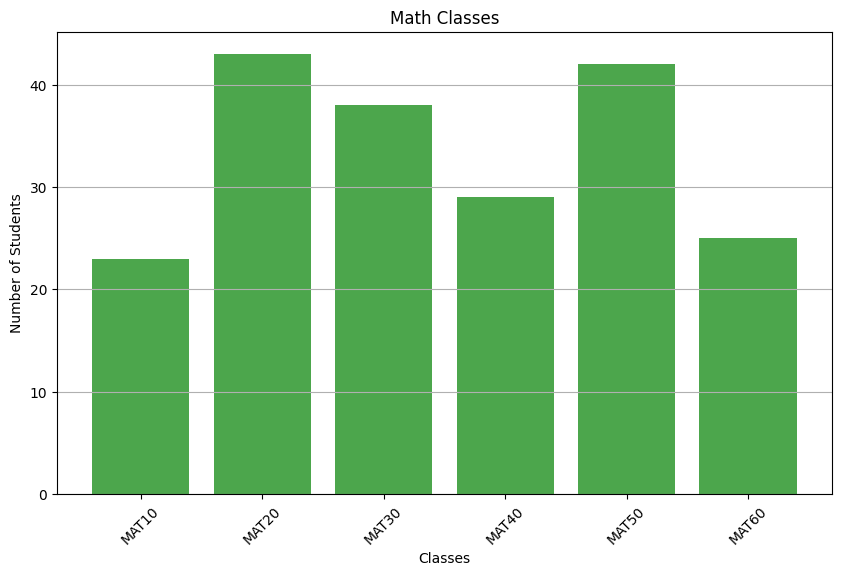

In [48]:
# plot the frequencies of each class for each subject
# english:
plt.figure(figsize=(10, 6))
plt.title("Math Classes")
plt.xlabel("Classes")
plt.ylabel("Number of Students")
plt.xticks(rotation=45)
plt.grid(axis='y')

# create a bar plot for all 5 math courses
plt.bar([math_courses[0].name, math_courses[1].name, math_courses[2].name, math_courses[3].name, math_courses[4].name, math_courses[5].name], [course_frequencies[math_courses[0].name], course_frequencies[math_courses[1].name], course_frequencies[math_courses[2].name], course_frequencies[math_courses[3].name], course_frequencies[math_courses[4].name], course_frequencies[math_courses[5].name]], color='green', alpha=0.7)


Zoomed in plot of the sciences

<BarContainer object of 7 artists>

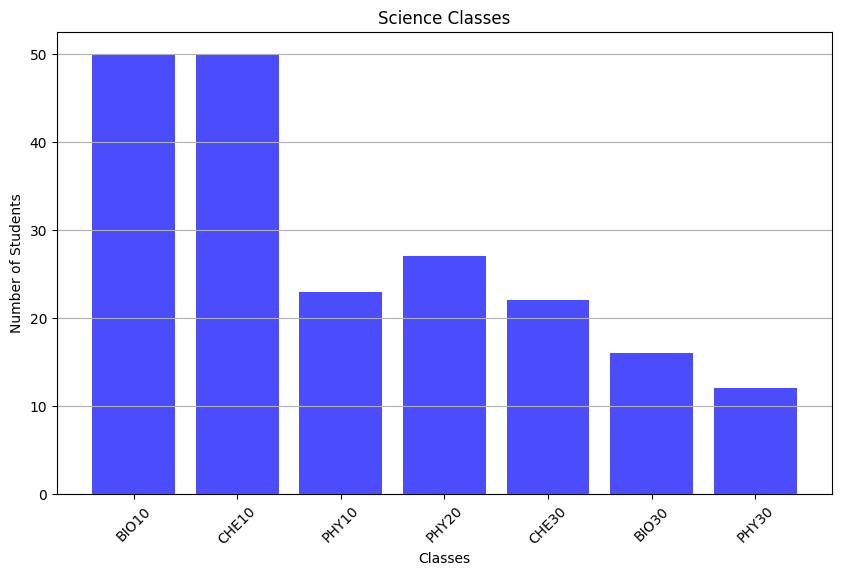

In [49]:
# plot the frequencies of each class for each subject
# english:
plt.figure(figsize=(10, 6))
plt.title("Science Classes")
plt.xlabel("Classes")
plt.ylabel("Number of Students")
plt.xticks(rotation=45)
plt.grid(axis='y')

# create a bar plot for all 7 science courses
plt.bar([science_courses[0].name, science_courses[1].name, science_courses[2].name, science_courses[3].name, science_courses[4].name, science_courses[5].name, science_courses[6].name], [course_frequencies[science_courses[0].name], course_frequencies[science_courses[1].name], course_frequencies[science_courses[2].name], course_frequencies[science_courses[3].name], course_frequencies[science_courses[4].name], course_frequencies[science_courses[5].name], course_frequencies[science_courses[6].name]], color='blue', alpha=0.7)

### Step 1: Determining the Number of Sections to Create

Starting with English, we rank the courses based on desirability. Then we create a section for each of them. Keep track of the saturation of blocks, assigning sections to the least saturated block.

In [50]:
for teacher in teachers:
    print(teacher)

Name: ENG Teacher 1. Teaching: {0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None}. Preferred: [ENG30]. Neutral: [ENG10, ENG20, ENG50, ENG60]. Unpreferred: [ENG40].
Name: ENG Teacher 2. Teaching: {0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None}. Preferred: [ENG50]. Neutral: [ENG10, ENG20, ENG30, ENG60]. Unpreferred: [ENG40].
Name: ENG Teacher 3. Teaching: {0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None}. Preferred: [ENG10]. Neutral: [ENG20, ENG40, ENG50, ENG60]. Unpreferred: [ENG30].
Name: ENG Teacher 4. Teaching: {0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None}. Preferred: [ENG20]. Neutral: [ENG10, ENG30, ENG50, ENG60]. Unpreferred: [ENG40].
Name: MAT Teacher 1. Teaching: {0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None}. Preferred: [MAT10]. Neutral: [MAT20, MAT30, MAT40, MAT50]. Unpreferred: [MAT60].
Name: MAT Teacher 2. Teaching: {0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None}. Preferred: [MAT10].

In [51]:
def reset_teachers():
    global block_sections
    for teacher in teachers:
        teacher.reset_schedule()
    for course in all_courses_flattened:
        course.reset_sections()

    block_sections = {i: [] for i in range(0, 7)}


## Future Note
Can generalize course overlaps by specifiying the following for each course:
 - the classes it's good to overlap with (i.e. eng 10 and eng 20)
 - the classes it's bad to overlap (i.e. math 60 and chamber ensemble)

In [52]:
reset_teachers()
block_sections: dict[int, list[Section]] = {i: [] for i in range(0, 7)}
def assign_block_and_teachers(courses: list[Course]):
    """Assigns blocks and teachers to the courses in the given list.
    
    Args:
        courses (list[Course]): List of Course objects.
    """
    # start with the least desirable course, so if a teacher prefers to teach an undersirable course, they get assgined to it.
    sorted_courses = sorted(courses, key=lambda x: x.get_course_desirability_teaching(), reverse=True)
    for course in sorted_courses:
        if course.finished_assigning_teachers:
            continue
        print(course)
        num_sections = math.ceil(course_frequencies[course.name] / MAX_CLASS_SIZE)
    
        for i in range(num_sections):
            teacher = course.get_best_teacher()
            if not teacher:
                print(f"No more available teachers for {course.name}")
                break

            # find the best free block for the teacher
            best_block = teacher.find_best_block_for_course(course, block_sections)

            print(f"Assigning {course.name} to block {best_block} with teacher {teacher.name}")
            section = course.create_section(teacher=teacher, block=best_block) # creating without students
            block_sections[best_block].append(section)
        course.finished_assigning_teachers = True

assign_block_and_teachers(ninth_grade_courses)
assign_block_and_teachers(tenth_grade_courses)
assign_block_and_teachers(eleventh_grade_courses)
assign_block_and_teachers(twelfth_grade_courses)

# add extra sections for the most popular classes for the teachers who don't have full schedules
for teacher in teachers:
    students_per_section: dict[Course, float] = {course: len(course.students)/len(course.sections) for course in teacher.preferred_courses + teacher.neutral_courses}
    while not teacher.has_full_schedule():
        
        best_course = max(students_per_section, key=students_per_section.get)

        # no need to split a class if there are less than 6 students in it
        # this is a heuristic to avoid splitting classes that are already small
        if students_per_section[best_course] < SMALLEST_SPLIT_THRESHOLD:
            break
    
        best_block = teacher.find_best_block_for_course(best_course, block_sections)
        section = best_course.create_section(teacher=teacher, block=best_block) # creating without students
        block_sections[best_block].append(section)

        students_per_section[best_course] = len(best_course.students)/len(best_course.sections) # update the number of students per section for the course

ENG10
Assigning ENG10 to block 2 with teacher ENG Teacher 3
Assigning ENG10 to block 6 with teacher ENG Teacher 3
Assigning ENG10 to block 3 with teacher ENG Teacher 3
ART40
Assigning ART40 to block 4 with teacher ART Teacher 2
COM10
Assigning COM10 to block 1 with teacher COM Teacher 3
Assigning COM10 to block 5 with teacher COM Teacher 3
ART30
Assigning ART30 to block 0 with teacher ART Teacher 4
Assigning ART30 to block 6 with teacher ART Teacher 4
MAT10
Assigning MAT10 to block 5 with teacher MAT Teacher 2
Assigning MAT10 to block 4 with teacher MAT Teacher 2
SPA30
Assigning SPA30 to block 3 with teacher SPA Teacher 4
Assigning SPA30 to block 2 with teacher SPA Teacher 4
Assigning SPA30 to block 1 with teacher SPA Teacher 4
Assigning SPA30 to block 0 with teacher SPA Teacher 4
Assigning SPA30 to block 6 with teacher SPA Teacher 1
MAT20
Assigning MAT20 to block 3 with teacher MAT Teacher 2
Assigning MAT20 to block 2 with teacher MAT Teacher 2
Assigning MAT20 to block 5 with teacher 

Let's see how we're doing. Sometimes we don't have enough teachers for all courses.

In [53]:
for course in all_courses_flattened:
    print(course.sections)

[ENG10 - 2: 0, ENG10 - 6: 0, ENG10 - 3: 0, ENG10 - 0: 0, ENG10 - 1: 0]
[ENG20 - 5: 0, ENG20 - 4: 0, ENG20 - 1: 0, ENG20 - 2: 0, ENG20 - 3: 0, ENG20 - 0: 0]
[ENG30 - 5: 0, ENG30 - 0: 0, ENG30 - 2: 0, ENG30 - 4: 0, ENG30 - 1: 0]
[ENG40 - 4: 0]
[ENG50 - 4: 0, ENG50 - 3: 0]
[ENG60 - 0: 0, ENG60 - 5: 0, ENG60 - 6: 0]
[MAT10 - 5: 0, MAT10 - 4: 0]
[MAT20 - 3: 0, MAT20 - 2: 0, MAT20 - 5: 0]
[MAT30 - 4: 0, MAT30 - 1: 0, MAT30 - 6: 0]
[MAT40 - 6: 0, MAT40 - 1: 0, MAT40 - 1: 0]
[MAT50 - 3: 0, MAT50 - 6: 0, MAT50 - 5: 0]
[MAT60 - 2: 0, MAT60 - 0: 0]
[BIO10 - 0: 0, BIO10 - 1: 0, BIO10 - 4: 0, BIO10 - 2: 0]
[CHE10 - 5: 0, CHE10 - 0: 0, CHE10 - 4: 0, CHE10 - 4: 0]
[PHY10 - 3: 0, PHY10 - 2: 0]
[PHY20 - 5: 0, PHY20 - 4: 0]
[CHE30 - 0: 0, CHE30 - 5: 0]
[BIO30 - 2: 0]
[PHY30 - 1: 0]
[HIS10 - 5: 0, HIS10 - 4: 0]
[HIS20 - 5: 0, HIS20 - 2: 0, HIS20 - 4: 0]
[HIS30 - 5: 0, HIS30 - 4: 0, HIS30 - 0: 0]
[HIS40 - 0: 0, HIS40 - 2: 0, HIS40 - 3: 0]
[HIS50 - 2: 0, HIS50 - 1: 0, HIS50 - 4: 0, HIS50 - 5: 0, HIS50 - 0:

### Assigning students to courses

Start with the course with the least # of sections.

Then, iterate over the sections, and for each student in that course:
- assign the students based on their scheudles, which has two parts.
    - Assign students with the least other classes also taught in this block (minimize conflict of schedules). If there is overlap, assign the students with the most # of available sections combined between their other courses (in theory, they are the most flexible)

- conflict resolution: if there are no available courses for a student:
    - first, try and move one of their other courses to accomodate.
    - if not possible, break the max class size limit and add a penalty
    - if still infeasible, make a note of that (sometimes conflicts are unavoidable depending on teacher schedules)
        - Potentially look at adding or shifting teacher schedules? (look at this later)

In [54]:
def reset_student_assignments():
    """
    Resets the course assignments for all students.
    """

    for student in students:
        student.reset_schedule()
    for course in all_courses_flattened:
        course.reset_students_in_sections()

50% weight class size, 50% weight student schedule. Emphasize clsas size actually so that there is as even a distribution as possible.


In [55]:
all_courses_electives = [course for course in all_courses_flattened if course.is_elective]
all_courses_required = [course for course in all_courses_flattened if not course.is_elective]

In [57]:
reset_student_assignments()

# sort the courses by the number of sections, so that we start with the ones with the least sections first
def assign_students_using_max_flow(courses: list[Course]) -> list[Course]:
    """
    Assigns students to sections using a max flow algorithm.

    Args:
        courses: a list of the courses to assign
    Returns:
        A list of courses that still need to be assigned students due to shuffeling.
    """
    sorted_courses = sorted(courses, key=lambda x: len(x.sections))

    courses_remaining: list[Course] = []
    for course in sorted_courses:
        ideal_students_per_section = math.ceil(len(course.students)/len(course.sections))

        # construct networkx graph, where each student is connected to each section they can take
        # each section is connected to a sink node
        # each student is connected to a source node
        G = nx.DiGraph()
        G.add_node("source")
        G.add_node("sink")

        blocks_to_sections: dict[str, Section] = {}
        for section in course.sections:
            G.add_node(section)
            G.add_edge(section, "sink", capacity=ideal_students_per_section)
            blocks_to_sections[section.block] = section

        unassigned_students: list[Student] = []
        students_to_assign: list[Student] = []
        already_enrolled = 0
        for student in course.students:
            # if the student is already assigned to a course in this section, skip them
            current_section = student.get_course_section(course)
            if student.get_course_section(course) != None:
                already_enrolled += 1
                G.edges()[(current_section, "sink")]["capacity"] -= 1
            
            else:
                students_to_assign.append(student)
                sections_for_student = student.get_available_sections_with_saturation(course)
                if len(sections_for_student) == 0:
                    unassigned_students.append(student)
                    continue
                G.add_node(student.name)
                G.add_edge("source", student.name, capacity=1)
                for section, saturation in sections_for_student.items():
                    # infinite capacity, weight is the saturation
                    G.add_edge(student.name, section, weight=saturation)
        

        # find the max flow min cost in the graph
        flow_dict = nx.max_flow_min_cost(G, "source", "sink")
        # assign the students to the sections based on the flow dict

        for student in students_to_assign:
            if student in unassigned_students:
                continue
            best_section = max(flow_dict[student.name], key=lambda x: flow_dict[student.name][x])
            if flow_dict[student.name][best_section] == 0:
                unassigned_students.append(student)
                continue
            best_section.add_student(student)

        # not all students were able to be assigned to a section, so we need to try to assign them to the sections with the least number of students and shuffle things around
        if len(unassigned_students) > 0:
            for student in unassigned_students:
                sections_sorted_by_size = sorted(course.sections, key=lambda x: len(x.students))
                
                assigned = False
                
                # try to assign the student to the section with the least number of students
                for min_size_section in sections_sorted_by_size:
                    if student.schedule[min_size_section.block] == None:
                        min_size_section.add_student(student)
                        assigned = True
                        break
                    if student.reassign_block(min_size_section.block, [min_size_section.block], 0):
                        # print("Succesfuuly reassigned student", student.name, "to section", min_size_section.block)
                        min_size_section.add_student(student)
                        assigned = True
                        break
                # if the student is not able to be assigned to any of the sections, they cannot take this course
                if not assigned:
                    print(f"Student {student.name} cannot be assigned to any sections for {course.name}.")
                    
                    # get student course preferences
                    for course_requests in student.course_requests:
                        has_alternative = False
                        try:
                            course_preference_rank = course_requests.index(course)
                            if course_preference_rank + 1 < len(course_requests):
                                has_alternative = True
                                next_course = course_requests[course_preference_rank + 1]
                            break
                        # haven't found the course in the list yet, so continue searching
                        except ValueError:
                            continue
                    
                    if not has_alternative:
                        print(f"Student {student.name} does not have any ranked alternative electives available.") 
                    else:
                        course.remove_student(student)
                        next_course.add_student(student)
                        courses_remaining.append(course)
    return courses_remaining  


courses_remaining = all_courses_required.copy()

count = 0
while len(courses_remaining) > 0:
    courses_remaining = assign_students_using_max_flow(courses_remaining)
    print("Iteration", count, "Courses remaining:", len(courses_remaining))
    count += 1

course_remaining = all_courses_electives.copy()

count = 0
while len(course_remaining) > 0:
    course_remaining = assign_students_using_max_flow(course_remaining)
    print("Iteration", count, "Courses remaining:", len(courses_remaining))
    count += 1

Iteration 0 Courses remaining: 0
Iteration 0 Courses remaining: 0


In [ ]:
reset_student_assignments()

# sort the courses by the number of sections, so that we start with the ones with the least sections first
def assign_students_using_max_flow(courses: list[Course]):
    """
    Assigns students to sections using a max flow algorithm.
    """
    sorted_courses = sorted(courses, key=lambda x: len(x.sections))
    for course in sorted_courses:
        ideal_students_per_section = math.ceil(len(course.students)/len(course.sections))

        # construct networkx graph, where each student is connected to each section they can take
        # each section is connected to a sink node
        # each student is connected to a source node
        G = nx.DiGraph()
        G.add_node("source")
        G.add_node("sink")

        blocks_to_sections: dict[str, Section] = {}
        for section in course.sections:
            G.add_node(section)
            G.add_edge(section, "sink", capacity=ideal_students_per_section)
            blocks_to_sections[section.block] = section

        unassigned_students: list[Student] = []
        for student in course.students:
            sections_for_student = student.get_available_sections_with_saturation(course)
            if len(sections_for_student) == 0:
                unassigned_students.append(student)
                continue
            G.add_node(student.name)
            G.add_edge("source", student.name, capacity=1)
            for section, saturation in sections_for_student.items():
                # infinite capacity, weight is the saturation
                G.add_edge(student.name, section, weight=saturation)
        

        # find the max flow min cost in the graph
        flow_dict = nx.max_flow_min_cost(G, "source", "sink")
        # assign the students to the sections based on the flow dict

        for student in course.students:
            if student in unassigned_students:
                continue
            best_section = max(flow_dict[student.name], key=lambda x: flow_dict[student.name][x])
            if flow_dict[student.name][best_section] == 0:
                unassigned_students.append(student)
                continue
            best_section.add_student(student)

        # not all students were able to be assigned to a section, so we need to try to assign them to the sections with the least number of students and shuffle things around
        if len(unassigned_students) > 0:
            for student in unassigned_students:
                sections_sorted_by_size = sorted(course.sections, key=lambda x: len(x.students))
                
                assigned = False
                
                # try to assign the student to the section with the least number of students
                for min_size_section in sections_sorted_by_size:
                    if student.schedule[min_size_section.block] == None:
                        min_size_section.add_student(student)
                        assigned = True
                        break
                    if student.reassign_block(min_size_section.block, [min_size_section.block], 0):
                        # print("Succesfuuly reassigned student", student.name, "to section", min_size_section.block)
                        min_size_section.add_student(student)
                        assigned = True
                        break
                # if the student is not able to be assigned to any of the sections, they cannot take this course
                if not assigned:
                    print(f"{student.name} cannot be assigned to any sections for {course.name}.")
                    continue 
assign_students_using_max_flow(all_courses_required)
assign_students_using_max_flow(all_courses_electives)


Student Student 29 Grade 12 cannot be assigned to any sections for ENG50.


In [58]:
students[102]

Student 3 Grade 11

Start with 1 subject. Then:

1. Assign the number of classes based on demand.

$n = \lceil \frac{\text{num students}}{\text{optimal class size}} \rceil$

2. Fix the classes within the school day.

3. Put students in classes based on student schedule

### Heuristic for assigning teachers to courses to maximize satisfaction:
Repeat:

2 rounds of scheduling all teachers who prefer teaching the course

1 round of teachers who are neutral to it

####  Assigning teachers to courses 
For teachers who both prefer teaching the same course.

- Assing a "pickiness" score to each teacher. +1 for P and U, +0 for neutral.

- Assign a "Desirability" rating for each class. +2 for P, +1 for N, +0 for U.

Start with the least desirable course. If there's a tie for preference between teachers, break the tie by assigning the pickiest teacher to that course first. Update the pickiness rating of each teacher as each class is assigned.

Notes:
- If a teacher dislikes teaching a course, avoid it if at all possible.


#### Assigning students to courses

- Start with the student with the least amount of flexibility. Flexibility is defined as:
    - ex. flexibility for english: 
    calculate the number of overlapping blocks with their math section, then history, then language. Sum these up

Popularity of a class = number of students registered / number of sections.



### Assigning courses to sections
Note: Create a class for Block, keeping track of all the sections corresponding to that block. That's an easy way to track oversaturated versus undersaturated blocks. Assign courses based on the least saturated block.

Constraint: each teacher teaches at most 4 sections

Evaluating a position:
- cost-to-go. Come up with a way to evaluate a position based on the features of it. (how constrained it is)

Compare all permutations of courses in which blocks.


What is the algorithm for assigning students?
- take all of the students that have that block free. Pick a random sample of them to fill it up. Since elective sare placed last, this should prioritize filling the required courses.

## 3 possible methods to consider

### 1. student first (prioritize student elective satisfaction)
Go through each student, place each class based on their schedule. If a class already exists (and the capacity is less than maxium amount), assign the student to that class, otherwise open a new section.

### 2. teacher first (prioritize number of blocks that teachers will teach)
Assign teacher schedules based on their desired teaching schedule. (i.e. 4 sections even w/50 students because teachers prefer only 4)

### 3. class sizes (prioritize size of each class)
Assign the total number of sections for each course first. (i.e. 5 sections b/c 50 students)

***********

Methods 2 and 3 are similar because you assign the teacher schedules first, then place the students.

In [59]:
student0 = students[102]
print(student0.name)
for block, section in student0.schedule.items():
    if section is not None:
        print(block, section.name)
    else:
        print(block, "Free")
print(student0.get_all_first_choice_courses())

Student 3 Grade 11
0 COM30
1 MAT40
2 HIS40
3 PHY10
4 Free
5 ENG30
6 SPA20
[ENG30, MAT40, PHY10, SPA20, HIS40, COM30]


In [60]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_schedule(people, n_people=10, person_type="Student"):
    fig, ax = plt.subplots(figsize=(10, 8))
    blocks = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    colors = ['#f4d03f', '#76d7c4', '#85c1e9', '#f1948a', '#bb8fce', '#FFA500', '#aed6f1']

    for block_idx, block in enumerate(blocks):
        # ax.add_patch(Rectangle((0, block_idx), 1, 1, color=colors[block_idx], label=f'{block} Block'))
        ax.text(-0.1, block_idx + 0.5, f'{block} Block', va='center', ha='right', fontsize=10, weight='bold')

    for person_idx, person in enumerate(people[:n_people]):  # Visualize only the first n students
        for block_idx, course in person.schedule.items():
            if course:
                ax.add_patch(Rectangle((person_idx, block_idx), 1, 1, color=colors[block_idx], alpha=0.7))
                ax.text(person_idx + .5, block_idx + 0.5, course.name, va='center', ha='center', fontsize=8)

    ax.set_xlim(0, len(people[:n_people]))
    ax.set_ylim(0, len(blocks))
    ax.set_xticks(range(1, len(people[:n_people]) + 1))
    ax.set_xticklabels([f'{person_type} {i+1}' for i in range(len(people[:n_people]))], rotation=45, ha='right')
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

# Call the function to visualize the schedule


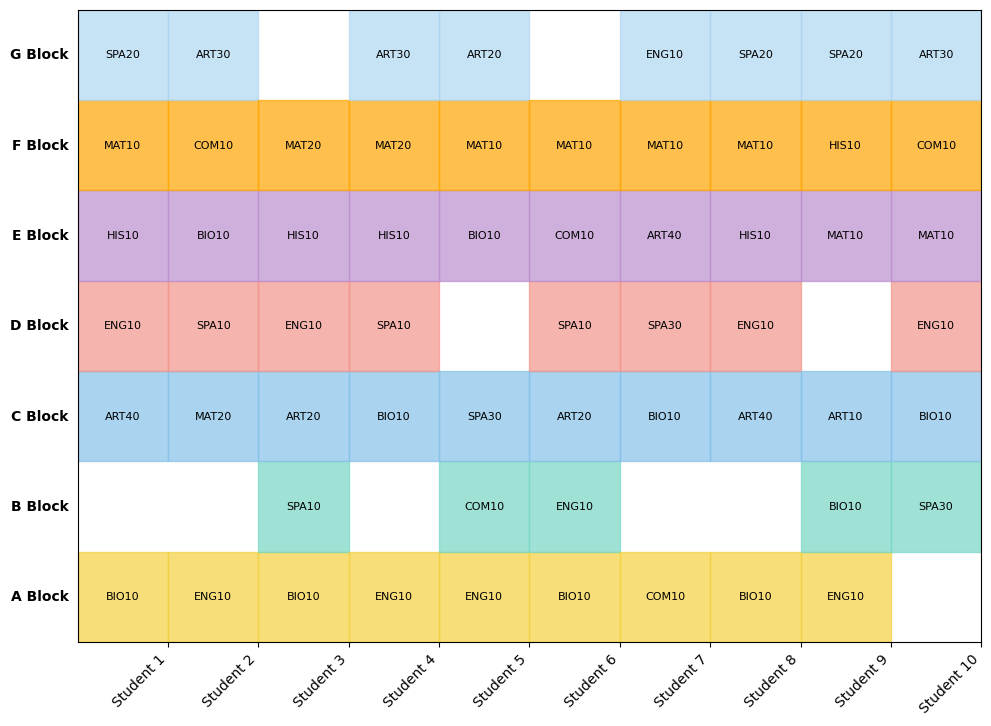

In [61]:
visualize_schedule(students)

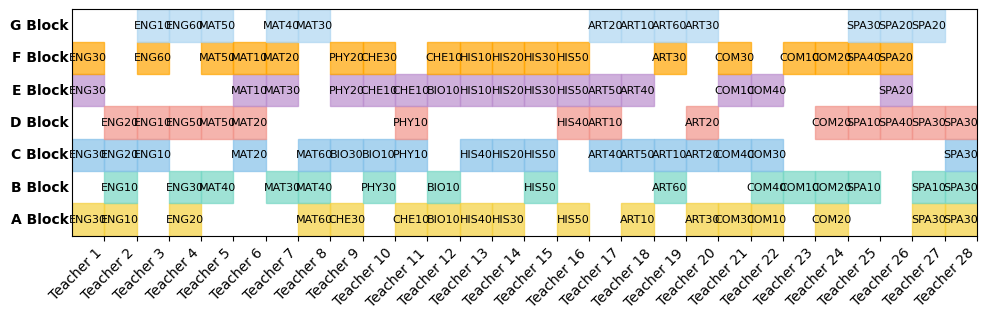

In [62]:
visualize_schedule(teachers, n_people=28, person_type="Teacher")

What about using matrices and vectors to represent state spaces?

## Evaluating a final schedule

Components:
- How many students don't get their first choice electives?
- How large are the classes? Penalize excessively large classes
- How evenly distributed are the classes? Compute mean and standard deviation

In [63]:
def cost_of_final_schedules(students: list[Student], courses: list[Course], teachers: list[Teacher]) -> int:
    """Calculates the cost of the final schedules based on the number of students in each section and the number of sections.
    
    Returns:
        int: The total cost of the final schedules.
    """
    total_cost = 0
    student_preference_penalty = 0
    infeasible_penalty = 0

    teacher_preference_penalty = 0
    lopsided_distribution_penalty = 0

    for student in students:
        schedule_courses = {section.course for section in student.schedule.values() if section is not None}
        if len(set(schedule_courses)) < len(schedule_courses):
            print("Student enrolled mutliple times in the same course!")
        # check that all students have their required courses
        for course in student.course_requests:
            course_found = False
            for i in range(len(course)):
                if course[i] in schedule_courses:
                    course_found = True
                    student_preference_penalty += i
                    break
            if not course_found:
                print(f"Student {student.name} is missing course {course}.")
                infeasible_penalty += 100
                # return math.inf

    for course in courses:
        num_sections = len(course.sections)

        # calculate mean and standard deviation of students per sections
        if num_sections > 0:
            students_per_section = [len(section.students) for section in course.sections]
            mean_students = np.mean(students_per_section)
            std_students = np.std(students_per_section)

            if std_students > 1 and std_students < 1.75:
                lopsided_distribution_penalty += 5
            elif std_students >= 1.75 and std_students < 2.5:
                lopsided_distribution_penalty += 10
            elif std_students > 2.5:
                lopsided_distribution_penalty += 50

            # create a numpy array of length num_sections with the number 8 in each entry
            # difference_from_ideal = np.full(num_sections, IDEAL_CLASS_SIZE) - students_per_section
            # for diff in difference_from_ideal:
            #     if diff > 0:
            #         total_cost += diff
            # print(students_per_section, difference_from_ideal, total_cost)
    total_cost = student_preference_penalty + infeasible_penalty + lopsided_distribution_penalty
    return total_cost

cost_of_final_schedules(students, all_courses_flattened, teachers)

95

Visualize all sections

In [64]:
for course in all_courses_flattened:
    for section in course.sections:
        print(f'{course.name} block {section.block}, {len(section.students)} students, {section.teacher.name}')
    print()

ENG10 block 2, 10 students, ENG Teacher 3
ENG10 block 6, 10 students, ENG Teacher 3
ENG10 block 3, 10 students, ENG Teacher 3
ENG10 block 0, 10 students, ENG Teacher 2
ENG10 block 1, 10 students, ENG Teacher 2

ENG20 block 5, 10 students, English Teacher 2
ENG20 block 4, 3 students, English Teacher 2
ENG20 block 1, 10 students, English Teacher 2
ENG20 block 2, 9 students, ENG Teacher 2
ENG20 block 3, 9 students, ENG Teacher 2
ENG20 block 0, 9 students, ENG Teacher 4

ENG30 block 5, 10 students, ENG Teacher 1
ENG30 block 0, 10 students, ENG Teacher 1
ENG30 block 2, 10 students, ENG Teacher 1
ENG30 block 4, 10 students, ENG Teacher 1
ENG30 block 1, 10 students, ENG Teacher 4

ENG40 block 4, 17 students, English Teacher 4

ENG50 block 4, 5 students, English Teacher 1
ENG50 block 3, 6 students, ENG Teacher 4

ENG60 block 0, 8 students, English Teacher 2
ENG60 block 5, 6 students, ENG Teacher 3
ENG60 block 6, 8 students, ENG Teacher 4

MAT10 block 5, 12 students, MAT Teacher 2
MAT10 block 4

# Rollout
For each student, assign them to a random section (take them out of the maxflow graph). Then run the heuristic and look at the cost. THen pick the bets section based on the results of the mutiple heuristic scenairos

## Local Improvement Algorithm

This algorithm iteratively improves the schedule by making small changes and accepting them if they reduce the cost.